In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch as tc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Downloading the Data

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
import os
try:
    if (not os.path.exists('./animefacedataset')):
        dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
        od.download(dataset_url)
    else:
        print('Dataset already downloaded')
except:
    print('Error in Downloading the dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sanskar457


Your Kaggle Key:

  ································


100%|██████████| 395M/395M [00:03<00:00, 118MB/s]  


In [4]:
Dir = './animefacedataset'
print(os.listdir(Dir))

['images']


In [5]:
print(len(os.listdir(Dir + '/images')))

63565


So, there are 63565 anime faces in the current folder.

# Exploring the data

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [7]:
img_size = 64
batch_size = 128
# normalization with assumption of mean and std as  0.5 for R,G and B channels
stats = (0.5,0.5,0.5),(0.5,.5,.5)

In [8]:
# Applying data transformation
train = ImageFolder(Dir,transform = tt.Compose([tt.Resize(img_size),tt.CenterCrop(img_size),tt.ToTensor(),tt.Normalize(*stats)]))
trainset = DataLoader(train,batch_size,shuffle = True) 

# Displaying a sample batch of images

In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# denormalizing the tensors to create the image
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    

def img_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

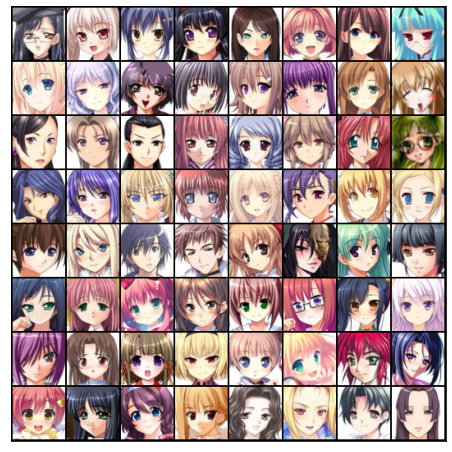

In [12]:
img_batch(trainset)

# Utilizing a GPU

In [13]:
def get_device():
    if tc.cuda.is_available():
        return tc.device('cuda')
    else:
        return tc.device('cpu')

device = get_device()
device

device(type='cuda')

In [14]:
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceLoader():
    def __init__(self, set, device):
        self.set = set
        self.device = device
        
    def __iter__(self):
        for b in self.set: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.set)
    
trainset = DeviceLoader(trainset, device)

# Discriminator Architecture

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    # LeakyReLU allows the passing of small negative gradients which is effective
    # for weight updation during generator training
    nn.LeakyReLU(.2,inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(.2,inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(.2,inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(.2,inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [16]:
discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

# Generator Architecture

We pass a latent vector of size of 128 to the generator which will try to convert it into a shape of 3x64x64 which is a typical image shape expected at the discriminator end.

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    
    # deconvolution
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # normalizing the output to a range of -1 to +1
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


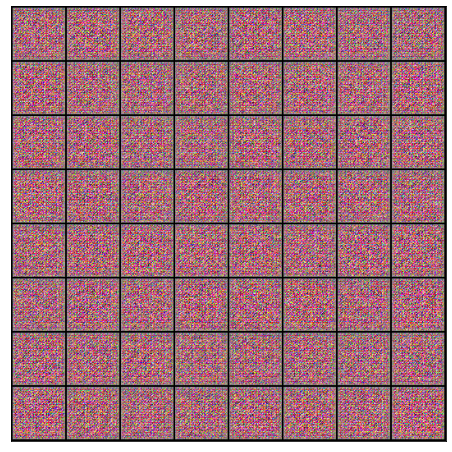

In [19]:
# passing random latent tensors through the generator
x = tc.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(x)
print(fake_images.shape)
show_images(fake_images,64)

In [20]:
generator.to(device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Discriminator Training

Binary cross entropy is utilized to calculate the loss in case of discriminator.

In [21]:
# real_images : anime faces present in the dataset
# optim_d : discriminators optimizer
def train_discriminator(real_images, optim_d):
    
    # Clearing discriminator gradients
    optim_d.zero_grad()

    # Passing real images through discriminator
    real_preds = discriminator(real_images)
    # Assigning all real image with a 1 label
    real_targets = tc.ones(real_images.size(0), 1, device=device)
    # Calculating the loss between real images and real labels
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    
    # Generating fake images
    latent = tc.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Passing fake images through discriminator by assigning fake image a 0 label
    # And calculating similar loss to real part
    fake_targets = tc.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    # Updating discriminator weights so that it get better at distinguishing 
    # between real and fake images
    loss = real_loss + fake_loss
    loss.backward()
    optim_d.step()
    return loss.item()

# Generator Training

Discriminator act as the loss function for optimizer. So, it is trained in such a way that it tries to decrease that loss to as minimum as possible such that it can easily fool the discriminator.

In [22]:
# optim_g : generators optimizer
def train_generator(optim_g):
    
    # Clearing generator gradients
    optim_g.zero_grad()
    
    # Generating fake images
    latent = tc.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Trying to fool the discriminator
    preds = discriminator(fake_images)
    # Setting target label to 1 so that optimization of gradients
    # occur in the direction of true labels for fake images also
    targets = tc.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Updating generator weights
    loss.backward()
    optim_g.step()
    
    return loss.item()

# Helper Function to save the image

In [23]:
from torchvision.utils import save_image

new_dir = 'generated_images'
os.makedirs(new_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=False):
    fake_images = generator(latent_tensors)
    fake_name = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(new_dir, fake_name), nrow=8)
    print('Saving', fake_name)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Training the model

In [25]:
# defining a fixed set of input latent vector to see the evolution of different generated images
fixed_latent = tc.randn(64,latent_size,1,1,device=device)

In [38]:
lr = 0.002                 # learning rate
Epochs = 25

def fit(Epochs,lr,start_idx = 1):
    
    tc.cuda.empty_cache()
    
    # list to store the losses for each epoch
    losses_g = []
    losses_d = []
    
    # Defining optimizers for discriminator and generator
    optim_d = tc.optim.Adam(discriminator.parameters(),lr = lr, betas = (0.5,0.999))
    optim_g = tc.optim.Adam(generator.parameters(),lr = lr, betas = (0.5,0.999))
    
    for epoch in range(Epochs):
        for real_images,labels in tqdm(trainset):
            
            # at first, train discriminator
            loss_d = train_discriminator(real_images, optim_d)
            
            # then, training the generator
            loss_g = train_generator(optim_g)
            
        print('Epoch : {}, Generator Loss : {:.4f}, Discriminator Loss : {:.4f}'.format(epoch+1,loss_g,loss_d))
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        
        # Saving the generated images
        save_samples(epoch+start_idx, fixed_latent)
        
    return losses_g, losses_d

In [39]:
model = fit(Epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 1, Generator Loss : 5.2763, Discriminator Loss : 0.0619
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 2, Generator Loss : 8.2994, Discriminator Loss : 0.3427
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 3, Generator Loss : 6.3473, Discriminator Loss : 0.2076
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 4, Generator Loss : 13.2524, Discriminator Loss : 1.1714
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 5, Generator Loss : 16.2293, Discriminator Loss : 1.2582
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 6, Generator Loss : 4.4411, Discriminator Loss : 0.1778
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 7, Generator Loss : 6.2756, Discriminator Loss : 0.1959
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 8, Generator Loss : 7.7622, Discriminator Loss : 0.1972
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 9, Generator Loss : 4.7306, Discriminator Loss : 0.8084
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 10, Generator Loss : 8.5146, Discriminator Loss : 0.0363
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 11, Generator Loss : 5.4782, Discriminator Loss : 0.0870
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 12, Generator Loss : 4.9659, Discriminator Loss : 0.0758
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 13, Generator Loss : 7.7282, Discriminator Loss : 0.1321
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 14, Generator Loss : 8.9894, Discriminator Loss : 0.0326
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 15, Generator Loss : 8.7722, Discriminator Loss : 0.1042
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 16, Generator Loss : 6.7972, Discriminator Loss : 0.0580
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 17, Generator Loss : 10.6581, Discriminator Loss : 0.1804
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 18, Generator Loss : 6.4585, Discriminator Loss : 0.0454
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 19, Generator Loss : 7.1444, Discriminator Loss : 0.0471
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 20, Generator Loss : 6.2313, Discriminator Loss : 0.0827
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 21, Generator Loss : 5.7723, Discriminator Loss : 0.0775
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 22, Generator Loss : 11.1286, Discriminator Loss : 0.0195
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 23, Generator Loss : 14.0617, Discriminator Loss : 0.2360
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 24, Generator Loss : 22.0836, Discriminator Loss : 0.8950
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch : 25, Generator Loss : 9.5404, Discriminator Loss : 0.0580
Saving generated-images-0025.png


# Visualizing loss change over time

In [41]:
losses_g, losses_d = model

Text(0.5, 1.0, 'Losses')

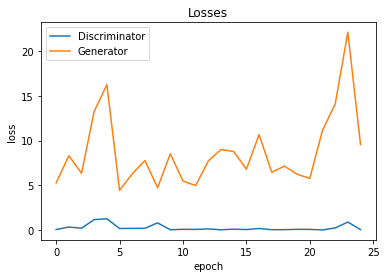

In [42]:
plt.plot(losses_d,'-')
plt.plot(losses_g)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

# Visualizing the generated images

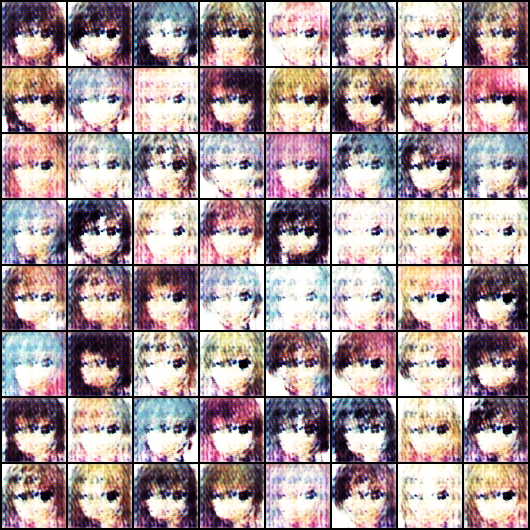

In [43]:
from IPython.display import Image

Image('/kaggle/working/generated_images/generated-images-0001.png')

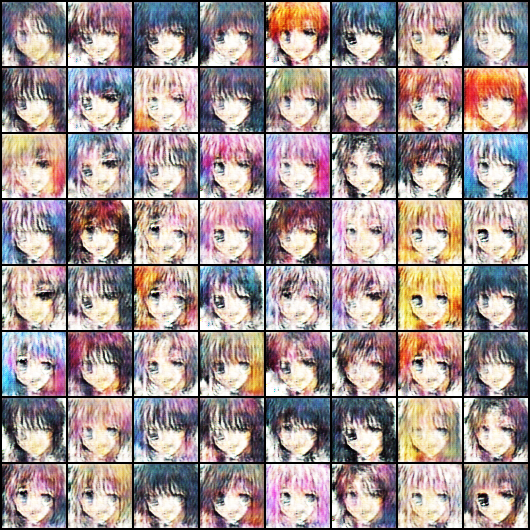

In [44]:
Image('/kaggle/working/generated_images/generated-images-0005.png')

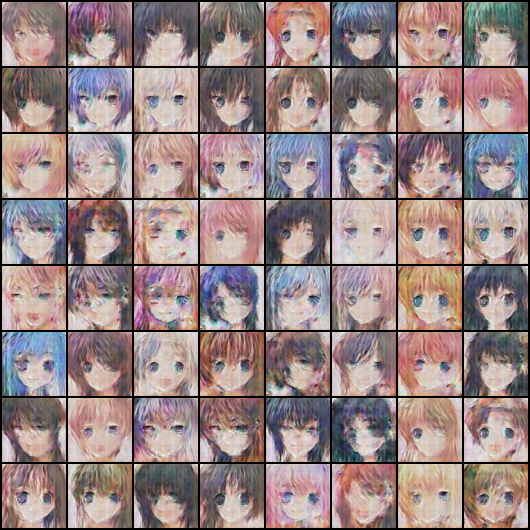

In [45]:
Image('/kaggle/working/generated_images/generated-images-0010.png')

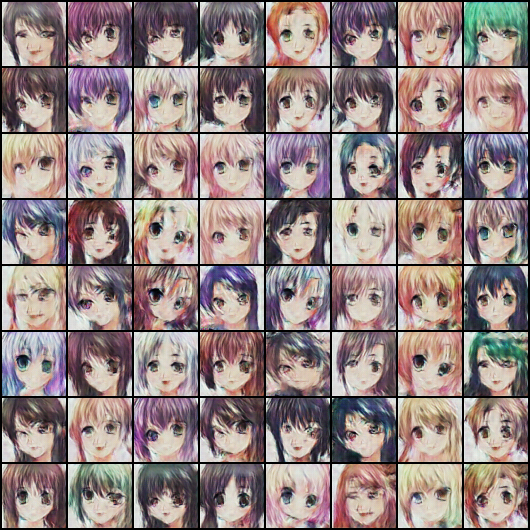

In [46]:
Image('/kaggle/working/generated_images/generated-images-0015.png')

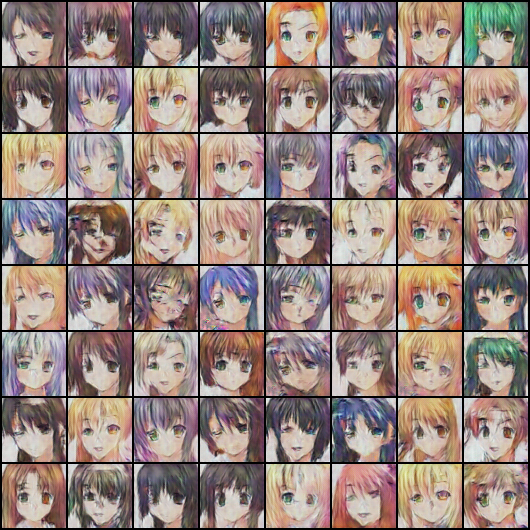

In [47]:
Image('/kaggle/working/generated_images/generated-images-0020.png')

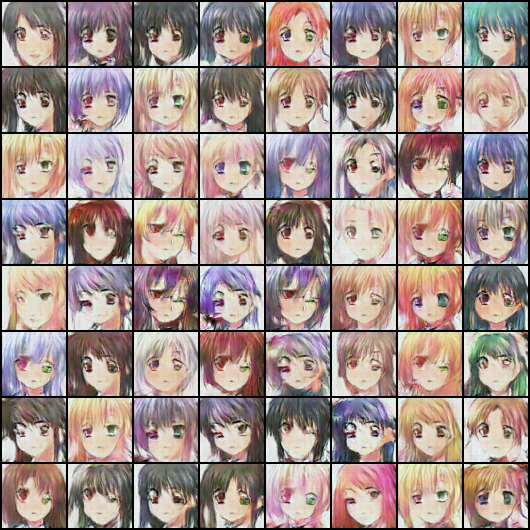

In [48]:
Image('/kaggle/working/generated_images/generated-images-0025.png')

We can clearly see that there is a gradual increase in the quality of generated images after a few epoch. After 25 epochs, some images are quite clear with proper definitions of an anime face. We can keep on training to recieve a much a clear anime faces which will be completely indistinguishable from the provided dataset. 